# “Downscaling and Bias Correction in Climate4R”

**Professors:**

Dr. Jorge Baño-Medina, Dra Josipa Milovac, Dr. Jesús Fernández
Instituto de Física de Cantabria (IFCA), CSIC-Universidad de Cantabria, Santander, España

Lic. Rocío Balmaceda-Huarte, Lic. Matías Olmo, Dra. María Laura Bettolli
Departamento de Ciencias de la Atmósfera y los Océanos-FCEN-UBA, Argentina

**Description of the notebook:** In this jupyter `R` notebook we show how to increase the spatial resolution of climate data by leaning on package `downscaleR`. The notebook is divided in 2 different parts entitled *Perfect-prognosis downscaling in climate4R* and *Bias correction in climate4R*. The companion `.pdf` file provides a basic explanation of these 2 methodologies ---perfect-prognosis and bias-correction. The case of studies developed in this notebook are framed in the COST action VALUE [1], which defines a set of downscaling experiments over Europe and South America [2].  

By the end of the notebook, the user would have acquired basic competences on the use of `downscaleR`. We refer the reader to either the GitHub climate4R repository (https://github.com/SantanderMetGroup/downscaleR) and the main reference manuscript [3] for more information.

To begin, we load the `R` libraries (please see previous notebook in module `01_Introduction` and/or the climate4R GitHub site (https://github.com/SantanderMetGroup/climate4R) for guidelines on the installation of the climate4R packages). In addition, we load the non-climate4R packages `RColorBrewer` for visualization purposes and `magrittr`.

In [2]:
### Climate4R libraries
library(loadeR)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(climate4R.value)

### Other libraries
library(RColorBrewer)
library(magrittr)

## Perfect-prognosis downscaling in climate4R
In this section we illustrate how to downscale based on the ``perfect-prognosis`` approach leaning on library `downscaleR`. We divide the section in 2 different parts. In the first one we describe how to cross-validate the statistical models, whilst in the second one we utilize the models to downscale historical and future (RCP8.5) emission scenarios. 

### Cross-validation
We perform a 3-fold cross-validation (1980-1987, 1988-1994, 1995-2000) to validate the statistical models (particularly, generalized linear models (GLM)). We use as the predictor and predictand datasets, ERA-Interim [2] and a set of VALUE stations, respectively. ERA-Interim is available in the User Data Gateway (UDG) in open-access, whilst the VALUE files can be found in the [VALUE cost ACTION site](http://www.value-cost.eu/data#netcdf).

We build the statistical models with the set of parameters defined below:

In [3]:
### Predictor variables
vars <- c("z@850", # geopotential 850 hPa
          "ta@850", "ta@700", "ta@500", # air temperature at 500, 700, 850 hPa
          "hus@700", # specific humidity at 700 hPa
          "va@850", # meridional wind velocity at 850 hPa
          "ua@850") # zonal wind velocity at 850 hPa

### Nº of closest predictor gridpoints
n <- 1

### Statistical model
method <- "GLM"
family <- gaussian(link = "identity")


### Folds
years <- 1980:2000
folds <- list(1980:1987,
              1988:1994,
              1995:2000)

### Latitude longitude boundaries
lonLim = c(-8,2)
latLim = c(36,44)

**Loading predictor data (reanalysis):** We use `dataInventory` function to list the variables contained in the ERA-Interim dataset located in UDG.

In [ ]:
### Remember to type ?UDG.datasets() to list the available datasets in UDG
di <- dataInventory('ECMWF_ERA-Interim-ESD')

C4R.vocabulary()

We input the UDG label associated to ERA-Interim into `loadGridData` function. Note that we feed a list of uni-grid climate4r objects ---each one containing the different predictor variables,--- to `makeMultiGrid` function to build the resulting multi-grid object.

In [ ]:
grid_x <- lapply(vars, FUN = function(var) {
  loadGridData(dataset = 'ECMWF_ERA-Interim-ESD', 
               var = var,
               years = years,
               lonLim = lonLim,
               latLim = latLim
              )    
}) %>% makeMultiGrid()

We use `spatialPlot` to display as an example the air temperature at 850 hPa.

[2022-08-26 09:13:46] - Computing climatology...

[2022-08-26 09:13:46] - Done.



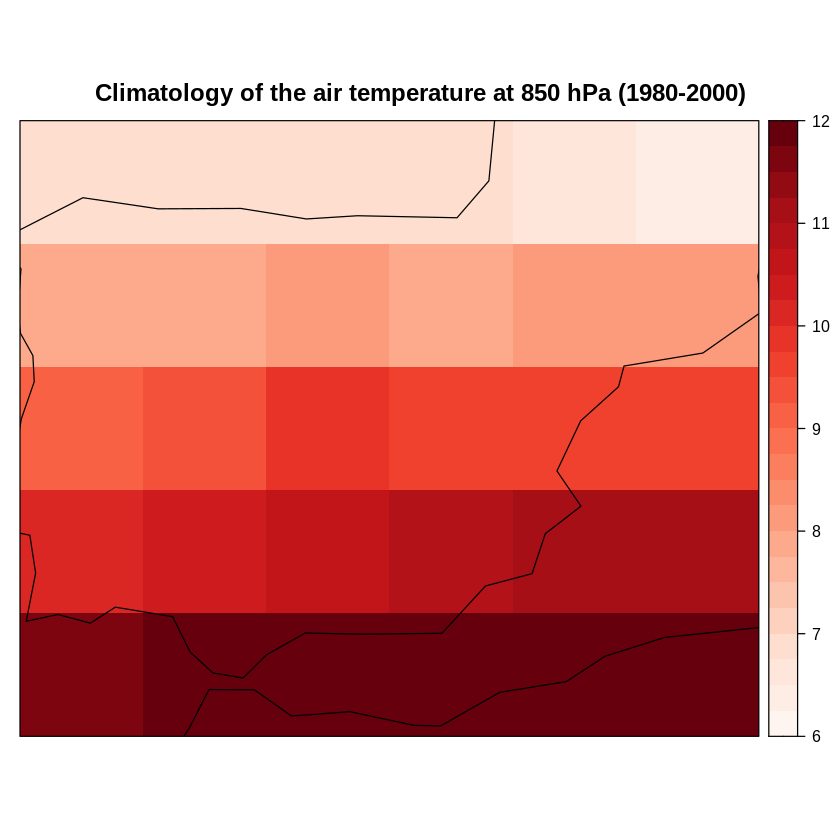

In [9]:
### Subset the air temperature at 850 hPa
grid_x_ta850 <- subsetGrid(grid_x, 
                           var = "ta@850")

### Define the color palette
color_palette <- colorRampPalette(brewer.pal(n = 9, "Reds"))

### Display the spatial map
spatialPlot(climatology(grid_x_ta850), 
            backdrop.theme = "coastline",
            at = seq(6, 12, 0.25),
            set.min = 6,
            set.max = 12,
            col.regions = color_palette,
            main = 'Climatology of the air temperature at 850 hPa (1980-2000)'
            )

### To free memory
rm(grid_x_ta850)

Let's take a look at a climate4R multi-grid object:

In [10]:
str(grid_x)

List of 4
 $ Variable:List of 2
  ..$ varName: chr [1:7] "z@850" "ta@850" "ta@700" "ta@500" ...
  ..$ level  : num [1:7] 850 850 700 500 700 850 850
  ..- attr(*, "use_dictionary")= chr [1:7] "TRUE" "TRUE" "TRUE" "TRUE" ...
  ..- attr(*, "description")= chr [1:7] "Geopotential" "Temperature" "Temperature" "Temperature" ...
  ..- attr(*, "units")= chr [1:7] "m2.s-2" "degC" "degC" "degC" ...
  ..- attr(*, "longname")= chr [1:7] "geopotential at different mbar levels" "air temperature at different mbar levels" "air temperature at different mbar levels" "air temperature at different mbar levels" ...
  ..- attr(*, "daily_agg_cellfun")= chr [1:7] "none" "none" "none" "none" ...
  ..- attr(*, "monthly_agg_cellfun")= chr [1:7] "none" "none" "none" "none" ...
  ..- attr(*, "verification_time")= chr [1:7] "none" "none" "none" "none" ...
 $ Data    : num [1:7, 1, 1:7671, 1:5, 1:6] 1.53e+04 5.90 1.42 -1.57e+01 9.88e-04 ...
  ..- attr(*, "dimensions")= chr [1:5] "var" "member" "time" "lat" ...
 $ x

**Loading predictand data:** We download the data from the VALUE cost ACTION site by calling function `download.file` 

In [11]:
predictand_path_to_file <- "./VALUE_europe.zip"
download.file(
    "http://www.value-cost.eu/sites/default/files/VALUE_ECA_86_v2.zip",
    predictand_path_to_file
)

We call `loadStationData` to load the mean of temperature (`tmean`) into our `R` environment.  

In [ ]:
y <- loadStationData(dataset = predictand_path_to_file, 
                     var = "tmean",
                     years = years,
                     lonLim = lonLim,
                     latLim = latLim
)  

In [15]:
str(y)

List of 5
 $ Variable:List of 2
  ..$ varName: chr "tmean"
  ..$ level  : NULL
  ..- attr(*, "units")= chr "degC"
 $ Data    : num [1:7671, 1:8] 11.4 9 3.8 4 4.6 2.2 0.4 4.4 3 5.2 ...
  ..- attr(*, "dimensions")= chr [1:2] "time" "loc"
 $ xyCoords:'data.frame':	8 obs. of  2 variables:
  ..$ x: num [1:8] -6.73 -6.83 -4.49 -4.01 -2.04 ...
  ..$ y: num [1:8] 41.8 38.9 36.7 40.8 43.3 ...
  ..- attr(*, "projection")= chr "+proj=longlat +init=epsg:4326 +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"
  ..- attr(*, "resX")= num 0
  ..- attr(*, "resY")= num 0
 $ Dates   :List of 2
  ..$ start: chr [1:7671] "1980-01-01 00:00:00" "1980-01-02 00:00:00" "1980-01-03 00:00:00" "1980-01-04 00:00:00" ...
  ..$ end  : chr [1:7671] "1980-01-02 00:00:00" "1980-01-03 00:00:00" "1980-01-04 00:00:00" "1980-01-05 00:00:00" ...
 $ Metadata:List of 4
  ..$ station_id: chr [1:8] "000212" "000229" "000231" "000232" ...
  ..$ name      : chr [1:8] "BRAGANCA" "BADAJOZ-TALAVERA LA REAL" "MALAGA" "NAVACERRADA" ...

In [26]:
y$Metadata$name

[1] "BRAGANCA"                      "BADAJOZ-TALAVERA LA REAL"     
[3] "MALAGA"                        "NAVACERRADA"                  
[5] "SAN-SEBASTIAN-IGUELDO"         "TORTOSA-OBSERVATORIO-DEL-EBRO"
[7] "TOULOUSE-BLAGNAC"              "MADRID-BARAJAS"

We use `spatialPlot` to display the climatology of the predictand field.

[2022-08-26 09:22:15] - Computing climatology...

[2022-08-26 09:22:15] - Done.



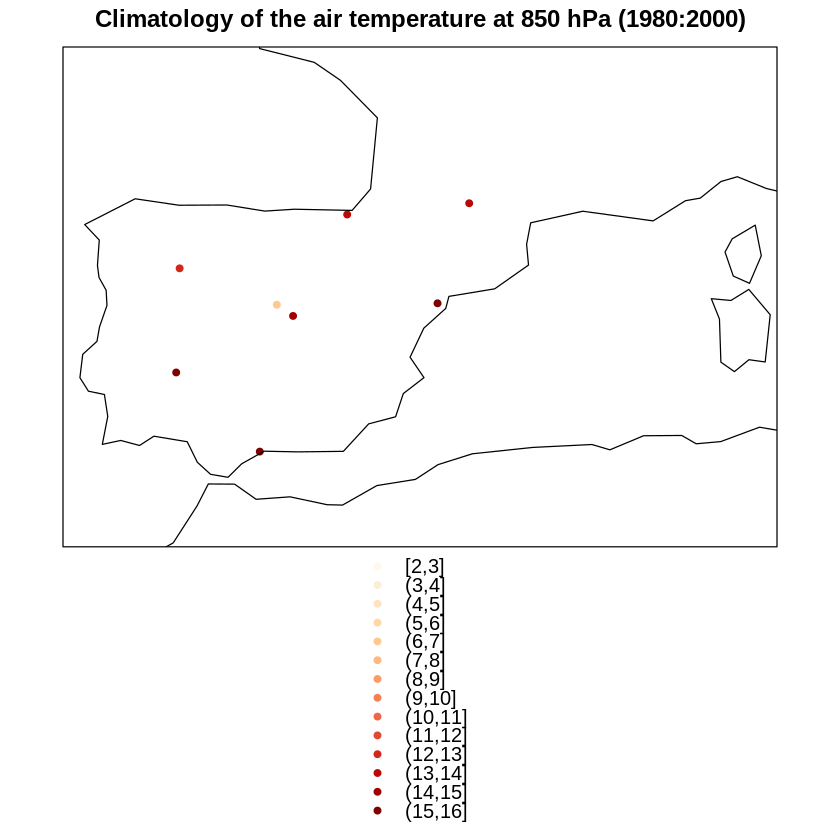

In [31]:
### Display the spatial map
spatialPlot(climatology(y), 
            xlim = c(-10,10),
            ylim = c(34,48),
            color.theme = "OrRd",
            cuts = seq(2,16,1),
            set.min = 2,
            set.max = 16,
            pch = 20,
            backdrop.theme = "coastline",
            main = 'Climatology of the air temperature at 850 hPa (1980:2000)'
            )

**Cross-validation**

We build a GLM using the variables contained in the closest predictor gridpoint to each site/predictand. Since we are focusing in the downscaling of temperature we use a Gaussian family with link identity (consider using other families for other variables, e.g., gamma for rainfall amount or Bernoulli for precipitation occurrence). We input the above defined `folds` object to indicate the cross-validation procedure.  The `scaleGrid.args` and `prepareData.args` parameters are function calls to `scaleGrid` and `prepareData` functions. We set these parameters to scale the predictor variables and to select the `n` closest predictor gridpoints (n = 1 in this example). 

In [34]:
pred_glm1 <- downscaleCV(grid_x,
                         y,
                         folds = folds, 
                         scaleGrid.args = list(type = "standardize"),
                         method = method, 
                         family = family,
                         prepareData.args = list("local.predictors" = list(vars = getVarNames(grid_x), 
                                                                           n = n)))

### Explore the prediction climate4R object
str(pred_glm1)

List of 5
 $ Variable:List of 2
  ..$ varName: chr "tmean"
  ..$ level  : NULL
  ..- attr(*, "units")= chr "degC"
  ..- attr(*, "subset")= chr "time"
  ..- attr(*, "time_subset")= chr "getTemporalIntersection"
 $ Data    : num [1:7671, 1:8] 7.19 5.45 7.38 7.32 5.82 ...
  ..- attr(*, "dimensions")= chr [1:2] "time" "loc"
 $ xyCoords:'data.frame':	8 obs. of  2 variables:
  ..$ x: num [1:8] -6.73 -6.83 -4.49 -4.01 -2.04 ...
  ..$ y: num [1:8] 41.8 38.9 36.7 40.8 43.3 ...
  ..- attr(*, "projection")= chr "+proj=longlat +init=epsg:4326 +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"
  ..- attr(*, "resX")= num 0
  ..- attr(*, "resY")= num 0
 $ Dates   :List of 2
  ..$ start: chr [1:7671] "1980-01-01 12:00:00 GMT" "1980-01-02 12:00:00 GMT" "1980-01-03 12:00:00 GMT" "1980-01-04 12:00:00 GMT" ...
  ..$ end  : chr [1:7671] "1980-01-01 12:00:00 GMT" "1980-01-02 12:00:00 GMT" "1980-01-03 12:00:00 GMT" "1980-01-04 12:00:00 GMT" ...
 $ Metadata:List of 4
  ..$ station_id: chr [1:8] "000212" "0002

Compute the root mean squared error (RMSE) of the prediction.

[2022-08-26 09:28:58] Computing member 1 out of 1

[2022-08-26 09:28:58] Done.



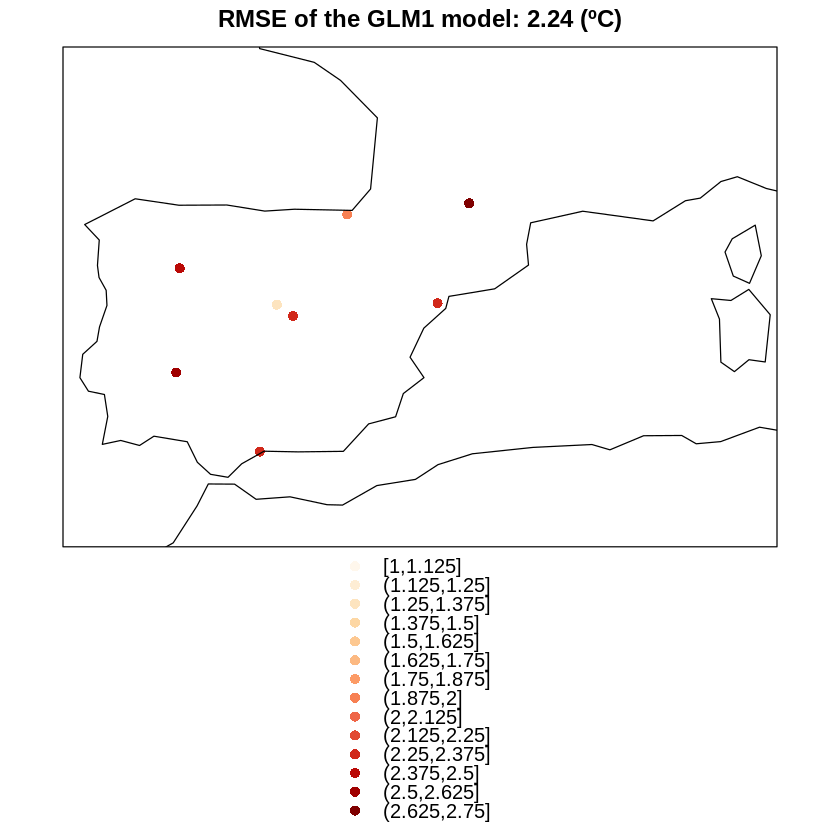

In [41]:
### ? show.measures()
rmse <- valueMeasure(y, pred_glm1, measure.code = "ts.RMSE")$Measure
rmse_averaged <- mean(rmse$Data, na.rm = TRUE) 

### Display the spatial RMSE field
spatialPlot(rmse, 
            xlim = c(-10,10),
            ylim = c(34,48),
            color.theme = "OrRd",
            cuts = seq(1,2.75,0.125),
            set.min = 1,
            set.max = 2.75,
            backdrop.theme = "coastline",
            main = sprintf('RMSE of the GLM1 model: %s (ºC)', round(rmse_averaged, digits = 2))
            )

**Exercise:** Cross-validate the `GLM1` (predictor is the closest gridpoint), `GLM4` and `GLM4-ta` (i.e., only using as predictors the air temperature variables) statistical models to downscale air surface temperature over the VALUE stations located in South America ([here](https://meteo.unican.es/work/training-climate4r-f43534662sfw/data/VALUE_South_America.zip) to download). Display the RMSE of the spatial maps. 

**Exercise:** Cross-validate the `GLM1` and `GLM4` statistical models to downscale total daily precipitation over the VALUE stations located in South America. Display the RMSE of the spatial maps. 

### Downscaling
In this section we describe how to calibrate statistical models to downscale global climate simulations. In particular we use the already cross-validated `GLM1` model of the previous section to downscale the historical and RCP8.5 emission scenarios of the 12th run of the EC-Earth climate model [6].

Below we define a set of parameters to perform the study. Note that for computational efficiency we have adopted 2 important decisions. On the one hand, we only select 2 predictors to drive the downscaling of air surface temperature. Despite informativeness capacity is lost against lower computational requirements, these predictors are known to carry a large fraction of the local variability of local temperature. On the other hand, we utilize only a 10-year period, whilst it is known that for climate studies is needed al least a 30-year period. 

In [75]:
### NOTE: For computational efficiency we only work with these two predictor variables
vars_reduced <- c("z@850", # geopotential 850 hPa
                  "ta@850") # air temperature 850 hPa


### NOTE: For computational efficiency we only work with 10-year temporal period
years_hist <- 1990:2000
years_rcp85 <- 2090:2100

### Labels EC-Earth in UDG
### remember ?UDG.datasets() for UDG labels
label_gcm_hist <- 'CMIP5-subset_EC-EARTH_r12i1p1_historical'
label_gcm_rcp85 <- 'CMIP5-subset_EC-EARTH_r12i1p1_rcp85'

**Loading predictor data (GCM):** We lean on the UDG to load the EC-Earth data. We call `loadGridData` to load the variables and the use `interpGrid` function to interpolate them to the predictor dataset used to calibrate the model in present conditions (i.e., ERA-Interim in our case, with 2ºx2º of lat-lon spatial resolution).

In [ ]:
### Loading the historical scenario (1990:2000)
grid_hist <- lapply(vars_reduced, FUN = function(var) {
    loadGridData(dataset = label_gcm_hist, 
                 var = var,
                 years = years_hist, 
                 lonLim = lonLim, 
                 latLim = latLim,
                ) %>% interpGrid(getGrid(grid_x)) # We interpolate the fields to match ERA-Interim spatial resolution  
}) %>% makeMultiGrid()

### Loading the RCP8.5 scenario (2090:2100)
grid_rcp85 <- lapply(vars_reduced, FUN = function(var) {
    loadGridData(dataset = label_gcm_rcp85, 
                 var = var,
                 years = years_rcp85, 
                 lonLim = lonLim, 
                 latLim = latLim,
                ) %>% interpGrid(getGrid(grid_x)) # We interpolate the fields to match ERA-Interim spatial resolution
}) %>% makeMultiGrid()

**Bias-correction of predictors:** We bias-correct the seasonal cycle of the predictors using the training predictor fields (object `grid_x_2` in the cell below). The function `scaleGrid` permits to scale the historical and future climate fields using the reanalysis field as base.

In [ ]:
### Parameters
bias_correction_type <- "center"
time.frame = 'monthly'

### Since we are working with a reduced predictor variable subset we call subsetGrid...
grid_x_2 <- subsetGrid(grid_x, var = vars_reduced)
rm(grid_x)

### Bias-correction historical scenario
grid_hist_bc <- scaleGrid(grid = grid_hist, 
                          base = grid_hist, 
                          ref = subsetGrid(grid_x_2, years = years_hist), 
                          type = bias_correction_type,
                          time.frame = time.frame)

### Scaling the RCP8.5 scenario
grid_rcp85_bc <- scaleGrid(grid = grid_rcp85, 
                           base = grid_hist,
                           ref = subsetGrid(grid_x_2, years = years_hist),
                           type = bias_correction_type,
                           time.frame = time.frame)

**Standardization of predictors:** We standardize the predictors using the training scaling parameters, i.e., the mean and variance of the ERA-Interim field used to calibrate the model. The function `scaleGrid` permits to scale the historical and future climate fields using the reanalysis field as base.

In [ ]:
### Parameters
standardization_type <- "standardize"

### Scaling the historical scenario
grid_hist_scaled <- scaleGrid(grid = grid_hist_bc, 
                              base = grid_x_2, 
                              type = standardization_type)

### Scaling the RCP8.5 scenario
grid_rcp85_scaled <- scaleGrid(grid = grid_rcp85_bc, 
                               base = grid_x_2, 
                               type = standardization_type)

### To free memory
# rm(grid_hist, grid_rcp85)

**Calibration of statistical models:** We calibrate the statistical model using the ERA-Interim and station data loaded in the cross-validation section above. However, in this case, instead of splitting the data into folds, we use the whole temporal period to calibrate the statistical model. We call `prepareData` function to prepare the data to feed the calibration function `downscaleTrain`, and select e.g., the number of closest predictor gridpoints to be used as explanatory variables. 

In [ ]:
grid_x_2_scaled <- scaleGrid(grid_x_2, type = "standardize")

grid_xy <- prepareData(x = grid_x_2_scaled,
                       y = y,
                       local.predictors = list(vars = vars_reduced, 
                                               n = n)
           )

Then we call `downscaleTrain` with the statistical method selected. 

In [102]:
model <- downscaleTrain(grid_xy, 
                        method = method, 
                        family = family)

**Prediction of statistical models:** Once the statistical model is calibrated and stored in object `model`, we call `prepareNewData` function to prepare the test data (i.e., climate simulation in our case) to feed the model. ..

In [116]:
### Prepare input data to downscale the historical scenario
grid_hist_scaled_input <- prepareNewData(newdata = grid_hist_scaled,
                                         data.structure = grid_xy)

### Prepare input data to downscale the RCP8.5 scenario
grid_rcp85_scaled_input <- prepareNewData(newdata = grid_rcp85_scaled,
                                          data.structure = grid_xy)

... and then call `downscalePredict` with the `model` object to dowscale the climate simulations. 

In [117]:
### Downscale the historical scenario
pred_hist <- downscalePredict(newdata = grid_hist_scaled_input, 
                              model = model)

### Downscale the RCP8.5 scenario
pred_rcp85 <- downscalePredict(newdata = grid_rcp85_scaled_input, 
                               model = model)

### To free memory
# rm(grid_x_2, grid_xy, grid_hist_scaled_input, grid_rcp85_scaled_input, grid_hist_scaled, grid_rcp85_scaled)

**Display the temporal serie maps**

In [118]:
str(y$Data)
str(pred_hist$Data)
str(pred_rcp85$Data)

 num [1:7671, 1:8] 11.4 9 3.8 4 4.6 2.2 0.4 4.4 3 5.2 ...
 - attr(*, "dimensions")= chr [1:2] "time" "loc"
 num [1:4018, 1:8] 6.51 9.5 13.28 15.06 14.16 ...
 - attr(*, "dimensions")= chr [1:2] "time" "loc"
 num [1:4017, 1:8] 14.68 15.13 9.84 9.28 11.56 ...
 - attr(*, "dimensions")= chr [1:2] "time" "loc"


pad applied on the interval: day

pad applied on the interval: day

pad applied on the interval: day

[2022-08-26 11:40:09] Performing annual aggregation...

[2022-08-26 11:40:09] Done.

[2022-08-26 11:40:09] Performing annual aggregation...

[2022-08-26 11:40:09] Done.

[2022-08-26 11:40:09] Performing annual aggregation...

[2022-08-26 11:40:09] Done.

pad applied on the interval: year

pad applied on the interval: year

pad applied on the interval: year



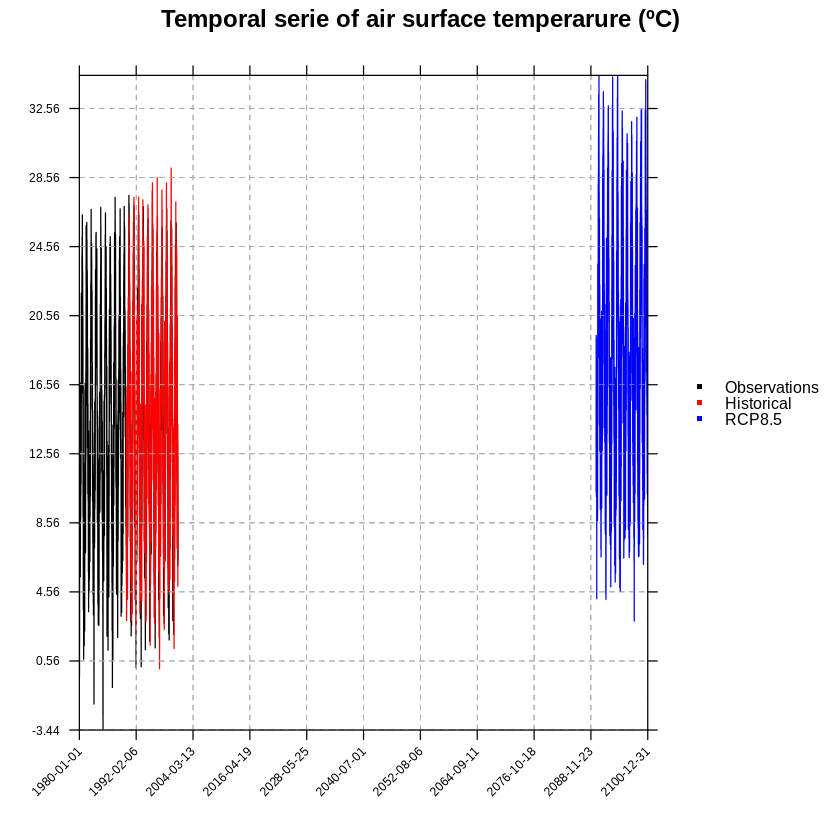

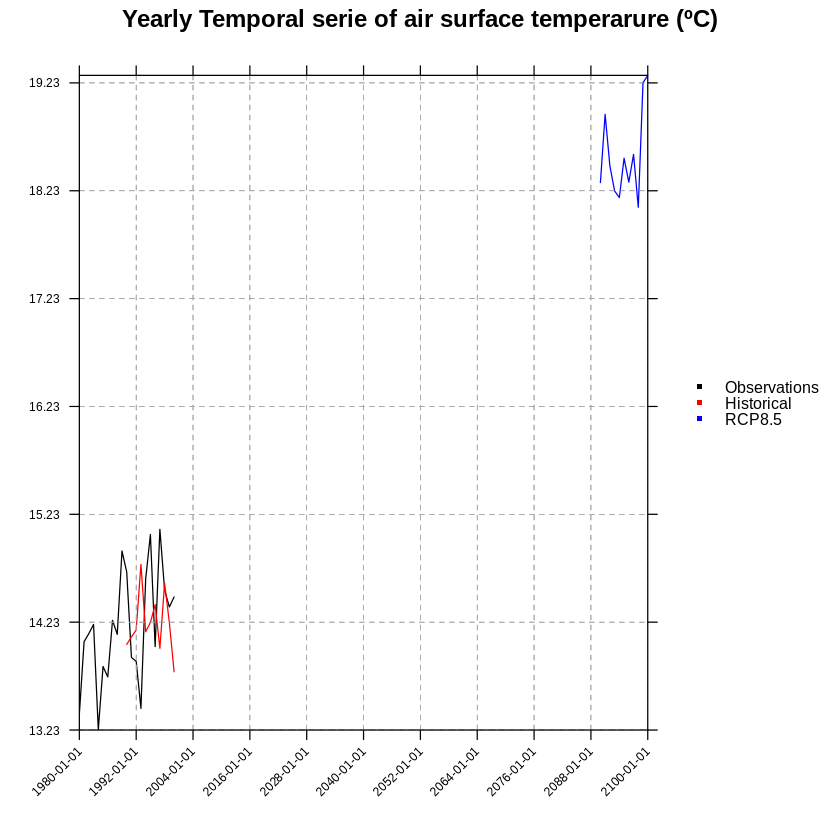

In [119]:
temporalPlot("Observations" = y, 
             "Historical" = pred_hist,
             "RCP8.5" = pred_rcp85,
             xyplot.custom = list(main = 'Temporal serie of air surface temperarure (ºC)',
                                  ylab = "", xlab = ""))

aggr.y.fun <- list(FUN = "mean", na.rm = TRUE)
temporalPlot("Observations" = aggregateGrid(y, aggr.y = aggr.y.fun), 
             "Historical" = aggregateGrid(pred_hist, aggr.y = aggr.y.fun),
             "RCP8.5" = aggregateGrid(pred_rcp85, aggr.y = aggr.y.fun),
             xyplot.custom = list(main = 'Yearly Temporal serie of air surface temperarure (ºC)',
                                  ylab = "", xlab = ""))


**Exercise:** For the South American VALUE stations, build the GLM1 and GLM4 statistical models to downscale the air surface temperature in the historical and RCP8.5 emission scenarios. 
 
 a) Display the spatial map with the climate change signal of the mean (i.e., difference between the climatological future and historical values).
 
 b) Display the temporal series with both the historical and RCP8.5 emission scenarios in the same graph.

**Exercise:** For the South American VALUE stations, build the GLM1 and GLM4 statistical models to downscale the total daily precipitation in the historical and RCP8.5 emission scenarios. 

a) Display the spatial map of the climate change signal of the mean (i.e., difference between the climatological future and historical values).

b) Display the spatial map of the climate change signal of the occurrence of precipitation (whenever the daily rainfall >= 1mm/day). Consider using function `binaryGrid`.


## Bias-correction in climate4R
In this section we describe how to perform bias correction with the `downscaleR` package. To do so, we work over the 12th run of the EC-Earth climate model [6]. In particular we utilize bias-correction method over the precipitation (`pr`) variable in both historical (1990-2000) and RCP8.5 (2090-2100) emission scenarios.

In [55]:
biasCorrection_var = 'pr'
working_with_precipitation <- "TRUE"
biasCorrection_method <- "eqm"
wet.threshold <- 1

**Load simulation data:** We call `loadGridData` function over the historical and RCP8.5 scenarios to load the precipitation in our `R` session. 

In [ ]:
pr_gcm_hist <- loadGridData(dataset = label_gcm_hist, 
                            var = biasCorrection_var,
                            years = years_hist, 
                            lonLim = lonLim, 
                            latLim = latLim
                            )  

pr_gcm_rcp85 <- loadGridData(dataset = label_gcm_rcp85, 
                             var = biasCorrection_var,
                             years = years_rcp85, 
                             lonLim = lonLim, 
                             latLim = latLim
                             )  

**Load observations data:** We use the set of local stations to be used to bias-correct the simulation data. In particular we use `loadStationData` to load the precipitation fields over the South American VALUE stations, similarly to what was done previously for the air surface temperature.

In [ ]:
pr_value <- loadStationData(dataset = predictand_path_to_file, 
                            var = "precip",
                            years = years_hist,
                            lonLim = lonLim,
                            latLim = latLim
)  

**Bias correction - Empirical Quantile Mapping (EQM):** The main `downscaleR` function to perform bias-correction is the `biasCorrection` function (please consider typing `?biasCorrection` for more information on this function). Below we show an example of using the empirical quantile method (`eqm`) to bias-correct the historical scenario. Note that the rainy days are defined as >= 1mm/day as indicated in the `wet.threshold` parameter. 

In [ ]:
### Historical scenario
eqmh <- biasCorrection(y = pr_value, 
                       x = pr_gcm_hist,
                       precipitation = working_with_precipitation,
                       method = biasCorrection_method,
                       wet.threshold = wet.threshold)

Since no observational reference exists in future periods, we feed the RCP8.5 precipitation field to the `newdata` parameter. The correction applied to each of the future quantiles (note we are using `eqm`) is the one derived from its equivalent field in the historical period and the observational reference.

In [ ]:
### RCP8.5 scenario
eqmf <- biasCorrection(newdata = pr_gcm_rcp85,
                       y = pr_value, 
                       x = pr_gcm_hist,
                       precipitation = working_with_precipitation,
                       method = biasCorrection_method,
                       wet.threshold = wet.threshold)

We compare the resulting distributions for a cerain local station.

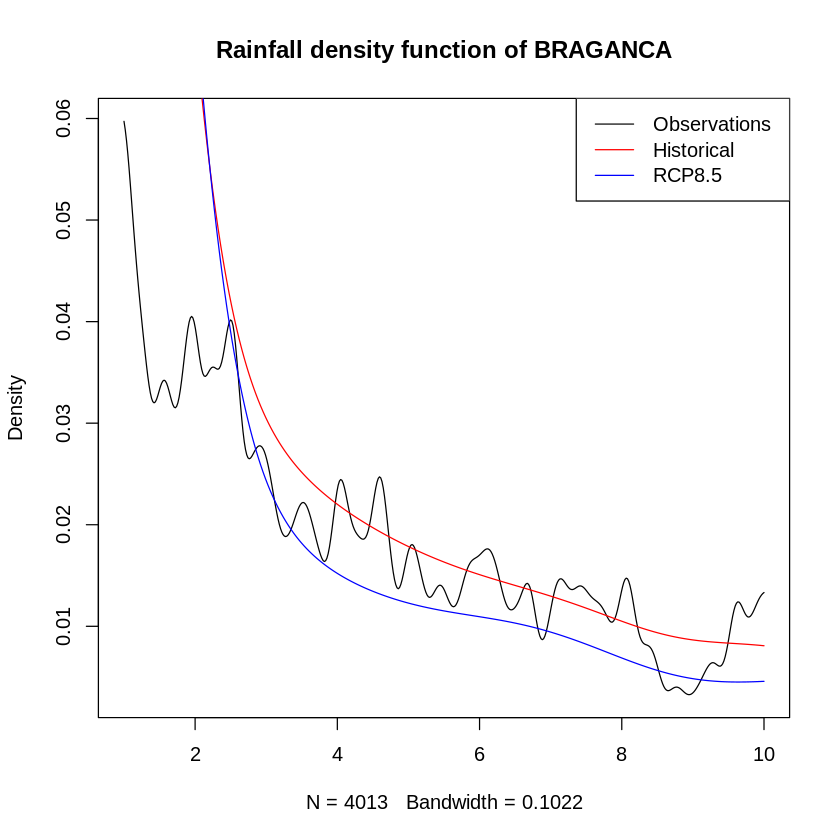

In [142]:
### Display the distribution for ***
### We work only with one station
num_station <- 1
station_id <- pr_value$Metadata$station_id[num_station]
pr_value_one <- subsetGrid(pr_value, station.id = station_id)
eqm_h_one <- subsetGrid(eqmh, station.id = station_id)
eqm_f_one <- subsetGrid(eqmf, station.id = station_id)

density(pr_value_one$Data, 
        na.rm = TRUE, 
        from = 1, 
        to = 10,
        ) %>% plot(main = sprintf("Rainfall density function of %s", pr_value$Metadata$name[num_station]))

density(eqm_h_one$Data, 
        na.rm = TRUE, 
        from = 1, 
        to = 10,
        ) %>% lines(col = "red")

density(eqm_f_one$Data, 
        na.rm = TRUE, 
        from = 1, 
        to = 10,
        ) %>% lines(col = "blue")

legend("topright", 
       legend = c("Observations", "Historical", "RCP8.5"), 
       col = c("black", "red", "blue"), 
       lty = c(1,1,1))


**Exercise:** Perform empirical quantile mapping of the RCP8.5 emission scenario over the South American VALUE stations. Display the spatial maps of the future mean climatology of the following variables: 
 
 a) Air surface temperature
 
 b) Total daily precipitation

## References

[1] Maraun, Douglas, et al. "VALUE: A framework to validate downscaling approaches for climate change studies." Earth's Future 3.1 (2015): 1-14.

[2] Maraun, Douglas, Martin Widmann, and José M. Gutiérrez. "Statistical downscaling skill under present climate conditions: A synthesis of the VALUE perfect predictor experiment." International Journal of Climatology 39.9 (2019): 3692-3703.

[3] Bedia, Joaquín, et al. "Statistical downscaling with the downscaleR package (v3. 1.0): contribution to the VALUE intercomparison experiment." Geoscientific Model Development 13.3 (2020): 1711-1735.

[4] Dee, Dick P., et al. "The ERA‐Interim reanalysis: Configuration and performance of the data assimilation system." Quarterly Journal of the royal meteorological society 137.656 (2011): 553-597.

[5] Cornes, Richard C., et al. "An ensemble version of the E‐OBS temperature and precipitation data sets." Journal of Geophysical Research: Atmospheres 123.17 (2018): 9391-9409.

[6] Doblas Reyes, Francisco, et al. "Using EC-Earth for climate prediction research." ECMWF Newsletter 154 (2018): 35-40.